# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.
 
Because we are using the full Amazon review dataset (not a subset of words or reviews), in this assignment we return to using Turi Create for its efficiency. As usual, let's start by **firing up Turi Create**.


In [47]:
import pandas as pd
import numpy as np
import string
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Load review dataset

For this assignment, we will use a subset of the Amazon product review dataset. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted primarily of positive reviews.

One column of this dataset is 'sentiment', corresponding to the class label with +1 indicating a review with positive sentiment and -1 indicating one with negative sentiment.

In [13]:
!ls

CLA09-NB01.ipynb
Week6_precision_recall_assignment_1.ipynb
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-9-assignment-test-idx.json.zip
_1ccb9ec834e6f4b9afb46f4f5ab56402_module-9-assignment-train-idx.json.zip
_596922c59a7068d4eb7baa104c01a685_amazon_baby.csv.zip
amazon_baby.csv
module-9-assignment-test-idx.json
module-9-assignment-train-idx.json
pNVbiuI5EemELQpo9cj5Ig_a6109214dc554e788678314e532e4dcf_CLA09-NB01.ipynb.zip
precision-recall.pdf


In [3]:
dtype_dict = {'name':str, 'review':str, 'rating':int }

In [4]:
products = pd.read_csv("amazon_baby.csv", dtype = dtype_dict)

In [5]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


## Perform text cleaning
We start by removing punctuation, so that words "cake." and "cake!" are counted as the same word.

Write a function remove_punctuation that strips punctuation from a line of text
Apply this function to every element in the review column of products, and save the result to a new column review_clean.

Refer to your tool's manual for string processing capabilities. Python lets us express the operation in a succinct way, as follows:

In [6]:
def remove_punctuation(text):
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

• Apply the remove_punctuation function on every element of the review column and assign the result to the new column review_clean. Note. Many data frame packages support apply operation for this type of task. Consult appropriate manuals.

We start with the first item as follows:

If your tool supports it, fill n/a values in the review column with empty strings. The n/a values indicate empty reviews. For instance, Pandas's the fillna() method lets you replace all N/A's in the review columns as follows:

In [8]:
products = products.fillna({'review':''})

In [9]:
products['review_clean'] = products['review'].apply(remove_punctuation)

## Extract Sentiments
We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment. In SFrame, for instance,

In [10]:
products = products[products['rating'] != 3]

Now, we will assign reviews with a rating of 4 or higher to be positive reviews, while the ones with rating of 2 or lower are negative. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label. A good way is to create an anonymous function that converts a rating into a class label and then apply that function to every element in the rating column. In SFrame, you would use apply():

In [11]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

## Split into training and test sets

In [16]:
with open('module-9-assignment-train-idx.json', 'r') as f: # Reads the list of most frequent words
    train_index = json.load(f)

In [17]:
train_data = products.iloc[train_index]

In [18]:
train_data.shape

(133416, 5)

In [19]:
products.shape

(166752, 5)

In [20]:
with open('module-9-assignment-test-idx.json', 'r') as f: # Reads the list of most frequent words
    test_index = json.load(f)

In [21]:
test_data = products.iloc[test_index]

In [22]:
test_data.shape

(33336, 5)

## Build the word count vector for each review
We will now compute the word count for each word that appears in the reviews. A vector consisting of word counts is often referred to as bag-of-word features. Since most words occur in only a few reviews, word count vectors are sparse. For this reason, scikit-learn and many other tools use sparse matrices to store a collection of word count vectors. Refer to appropriate manuals to produce sparse word count vectors. General steps for extracting word count vectors are as follows:

Learn a vocabulary (set of all words) from the training data. Only the words that show up in the training data will be considered for feature extraction.
Compute the occurrences of the words in each review and collect them into a row vector.
Build a sparse matrix where each row is the word count vector for the corresponding review. Call this matrix train_matrix.
Using the same mapping between words and columns, convert the test data into a sparse matrix test_matrix.
The following cell uses CountVectorizer in scikit-learn. Notice the token_pattern argument in the constructor.

In [24]:

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [26]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\b\\w+\\b', tokenizer=None,
                vocabulary=None)

In [27]:
train_matrix.shape

(133416, 121712)

## Train a sentiment classifier with logistic regression
Learn a logistic regression classifier using the training data. If you are using scikit-learn, you should create an instance of the LogisticRegression class and then call the method fit() to train the classifier. This model should use the sparse word count matrix (train_matrix)as features and the column sentiment of train_data as the target. Use the default values for other parameters. Call this model model.

In [29]:
model = LogisticRegression()

In [31]:
model.fit(train_matrix, train_data['sentiment'])

/Users/amitpatel/anaconda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Evaluation

We will explore the advanced model evaluation concepts that were discussed in the lectures.

## Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments.  Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

To obtain the accuracy of our trained models using Turi Create, simply pass the option `metric='accuracy'` to the `evaluate` function. We compute the **accuracy** of our logistic regression model on the **test_data** as follows:

In [34]:
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy(), y_pred=model.predict(test_matrix))
print ("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9318154547636189


## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [36]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print ("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


**Quiz Question:** Using accuracy as the evaluation metric, was our **logistic regression model** better than the baseline (majority class classifier)?

## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [40]:
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3782
     -1       |        1        |  1459
      1       |       -1        |   814
      1       |        1        | 27281


**Quiz Question**: How many predicted values in the **test set** are **false positives**?

In [41]:
1459

1459

In [95]:
1459/(1459+27281)

0.05076548364648573

## Computing the cost of mistakes


Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

**Quiz Question**: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?

In [42]:
(1459*100) + (814*1)

146714

## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

First, let us compute the precision of the logistic regression classifier on the test_data. Scikit-learn provides a predefined method for computing precision. (Consult appropriate manuals if you are using other tools.)

In [45]:
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print ("Precision on test data: %s" % precision)

Precision on test data: 0.9492345163535143


**Quiz Question**: Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)

**Quiz Question:** Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would (select one):

- Discard a sufficient number of positive predictions
- Discard a sufficient number of negative predictins
- Increase threshold for predicting the positive class ($y_{hat} = +1$)
- Decrease threshold for predicting the positive class ($y_{hat} = +1$)



A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

In [48]:
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print ("Recall on test data: %s" % recall)

Recall on test data: 0.9710268731090942


In [102]:
round(0.9710268731090942,2)

0.97

**Quiz Question**: What fraction of the positive reviews in the **test_set** were correctly predicted as positive by the classifier?

**Quiz Question**: What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?

# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  


## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

The function should return an SArray, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [49]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    return [+1 if probability > threshold else -1 for probability in probabilities]

Using the model you trained, compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

Note. If you are using scikit-learn, make sure to use predict_proba() function, not decision_function(). Also, note that the predict_proba() function returns the probability values for both classes +1 and -1. So make sure to extract the second column, which correspond to the class +1.

In [53]:
test_data_probabilities = model.predict_proba(test_matrix)[:,1]

In [54]:
predictions_with_default_threshold = apply_threshold(test_data_probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(test_data_probabilities, 0.9)

In [61]:
np.array(predictions_with_high_threshold)

array([1, 1, 1, ..., 1, 1, 1])

In [57]:
print("Number of positive predicted reviews (threshold = 0.5): %s" % sum(np.array(predictions_with_default_threshold) == 1))

Number of positive predicted reviews (threshold = 0.5): 28740


In [62]:
print("Number of positive predicted reviews (threshold = 0.9): %s" % sum(np.array(predictions_with_high_threshold) == 1))

Number of positive predicted reviews (threshold = 0.9): 24599


**Quiz Question**: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. We can explore this as follows:

In [64]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred = predictions_with_default_threshold)

recall_with_default_threshold = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred = predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                                        y_pred = predictions_with_high_threshold)
recall_with_high_threshold = recall_score(y_true=test_data['sentiment'].to_numpy(),
                                        y_pred = predictions_with_high_threshold)

In [65]:
print("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

Precision (threshold = 0.5): 0.9492345163535143
Recall (threshold = 0.5)   : 0.9710268731090942


In [66]:
print("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.9): 0.983373307858043
Recall (threshold = 0.9)   : 0.8610072966720057


**Quiz Question (variant 1)**: Does the **precision** increase with a higher threshold?

**Quiz Question (variant 2)**: Does the **recall** increase with a higher threshold?

## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [67]:
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

For each of the values of threshold, we compute the precision and recall scores.

In [68]:
precision_all = []
recall_all = []

probabilities = model.predict_proba(test_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred = predictions)
    recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred = predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

/Users/amitpatel/anaconda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now, let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

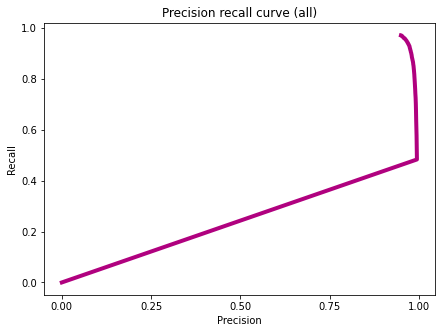

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [75]:
new_list = []
for i in zip(threshold_values, precision_all):
    thre, preci = i
   
    if preci >= 0.965:
        new_list.append(thre) 
        
print (min(new_list))

0.6919191919191919


In [76]:
threshold_values[38]

0.6919191919191919

**Quiz Question**: Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? 

In [77]:
predictions_98 = apply_threshold(test_data_probabilities, 0.98)

In [78]:
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=predictions_98,
                        labels=model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5077
     -1       |        1        |   164
      1       |       -1        |  9203
      1       |        1        | 18892


This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

In [79]:
9203

9203

# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the **test set**, select all the reviews for all products with the word 'baby' in them.

In [80]:
test_data.head()

,name,review,rating,review_clean,sentiment
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1
16,Nature's Lullabies First Year Sticker Calendar,"I love this little calender, you can keep trac...",5,I love this little calender you can keep track...,1
20,Nature's Lullabies Second Year Sticker Calendar,I had a hard time finding a second year calend...,5,I had a hard time finding a second year calend...,1
28,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,One of babys first and favorite books and it i...,1


In [85]:
test_data = test_data.fillna({'name':''})

In [86]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [88]:
baby_reviews.head()

,name,review,rating,review_clean,sentiment
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1
56,Baby's First Year Undated Wall Calendar with S...,I searched high and low for a first year calen...,5,I searched high and low for a first year calen...,1
59,Our Baby Girl Memory Book,Absolutely love it and all of the Scripture in...,5,Absolutely love it and all of the Scripture in...,1
112,Newborn Baby Tracker&reg; - Round the Clock Ch...,This is the best way to keep track of when you...,5,This is the best way to keep track of when you...,1


Now, let's predict the probability of classifying these reviews as positive. Make sure to convert the column review_clean of baby_reviews into a 2D array before computing class probability values. In scikit-learn, this task would be implemented as follows:

In [89]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities_baby_data = model.predict_proba(baby_matrix)[:,1]

Let's plot the precision-recall curve for the **baby_reviews** dataset.

**First**, let's consider the following `threshold_values` ranging from 0.5 to 1:

In [90]:
threshold_values = np.linspace(0.5, 1, num=100)

**Second**, as we did above, let's compute precision and recall for each value in `threshold_values` on the **baby_reviews** dataset.  Complete the code block below.

In [91]:
precision_all_baby = []
recall_all_baby = []

for threshold in threshold_values:
    predictions = apply_threshold(probabilities_baby_data, threshold)
    
    precision = precision_score(y_true=baby_reviews['sentiment'].to_numpy(), 
                            y_pred = predictions)
    recall = recall_score(y_true=baby_reviews['sentiment'].to_numpy(),
                      y_pred = predictions)
    
    precision_all_baby.append(precision)
    recall_all_baby.append(recall)

/Users/amitpatel/anaconda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better for the reviews of data in **baby_reviews**? Round your answer to 3 decimal places.

In [93]:
new_list = []
for i in zip(threshold_values, precision_all_baby):
    thre, preci = i
   
    if preci >= 0.965:
        new_list.append(thre) 
        
print (min(new_list))

0.696969696969697


**Quiz Question:** Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

**Finally**, let's plot the precision recall curve.

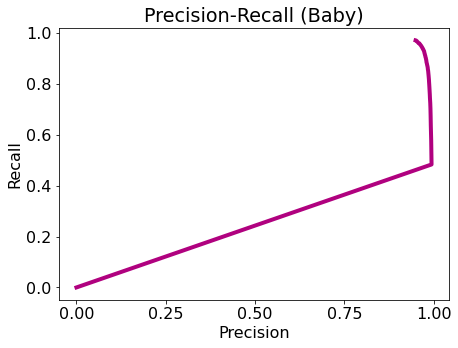

In [94]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")